### **0. Подготовка обучающей и тестовой выборки**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
%matplotlib inline 
sns.set(style="ticks")

In [2]:
# Будем использовать только обучающую выборку
data = pd.read_csv('data/train.csv', sep=",")

In [3]:
X = data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]  # Пример признаков
y = data['Survived']  # Целевая переменная (1 - выжил, 0 - не выжил)
# Разделение на train и test (сначала split, потом обработка, чтобы избежать data leakage)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [4]:
data = data.dropna(subset=['Embarked'])
data = data.drop('Cabin', axis=1)

In [5]:
numeric_features = ['Age', 'SibSp', 'Parch', 'Fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Заполняем пропуски медианой
    ('scaler', StandardScaler())  # Масштабируем
])

In [6]:
categorical_features = ['Sex', 'Pclass']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Заполняем пропуски модой
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Кодируем категории
])

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [8]:
# Применяем преобразования
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [9]:
X_train_processed

array([[-1.91971935, -0.47416141,  1.99885349, ...,  1.        ,
         0.        ,  0.        ],
       [-0.0772525 , -0.47416141, -0.47932706, ...,  0.        ,
         0.        ,  1.        ],
       [-2.15002771,  0.34868694,  0.75976322, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.92075038,  1.17153529, -0.47932706, ...,  0.        ,
         0.        ,  1.        ],
       [-1.15202483,  0.34868694,  1.99885349, ...,  1.        ,
         0.        ,  0.        ],
       [-0.61463866, -0.47416141,  0.75976322, ...,  1.        ,
         0.        ,  0.        ]])

### **1. Обучение моделей**

#### **1.1 Логистическая регрессия (т.к. задача классификации)**

сигмоида с e^(w1x1 + w2x2 + wnxn) в знаменателе, обучение происходит так:
1) инициализация весов случайными малыми числами
2) прямой проход (для каждого пассажира вычисляется z = w0 + w1 * sex + w2 * fare + ... , а затем приминяется сигмоида чтобы получить вероятность выживания)
3) функция потерь (используется log loss)
4) градиентный спуск (вычисляются градиенты (производные ошибки по весам) и корректируются веса (wj = wj - a * произв Loss по wj)) a - скорость обучения

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Создаем общий pipeline с моделью
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

print("Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1-score:", f1_score(y_test, y_pred_lr))

Logistic Regression:
Accuracy: 0.8134328358208955
F1-score: 0.7572815533980582


#### **1.2 SVM (Support Vector Machine)**

почти то же, только ищет гиперплоскость, минимизирует другую функцию, и использует какие-то ядра..)

In [11]:
from sklearn.svm import SVC

svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', probability=True))
])

svm_pipeline.fit(X_train, y_train)
y_pred_svm = svm_pipeline.predict(X_test)

print("\nSVM:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("F1-score:", f1_score(y_test, y_pred_svm))


SVM:
Accuracy: 0.8283582089552238
F1-score: 0.7788461538461539


#### **1.3 Дерево решений**

Разбивает ветку пока не дойдет до максимальной глубины или максимального числа объектов в узле (склонно к переобучению)

In [12]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=3, random_state=42))
])

dt_pipeline.fit(X_train, y_train)
y_pred_dt = dt_pipeline.predict(X_test)

print("\nDecision Tree:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("F1-score:", f1_score(y_test, y_pred_dt))


Decision Tree:
Accuracy: 0.8171641791044776
F1-score: 0.7609756097560976


SVM показал себя лучше по обоим показателям, но разница небольшая

### **2. Еще про дерево решений**

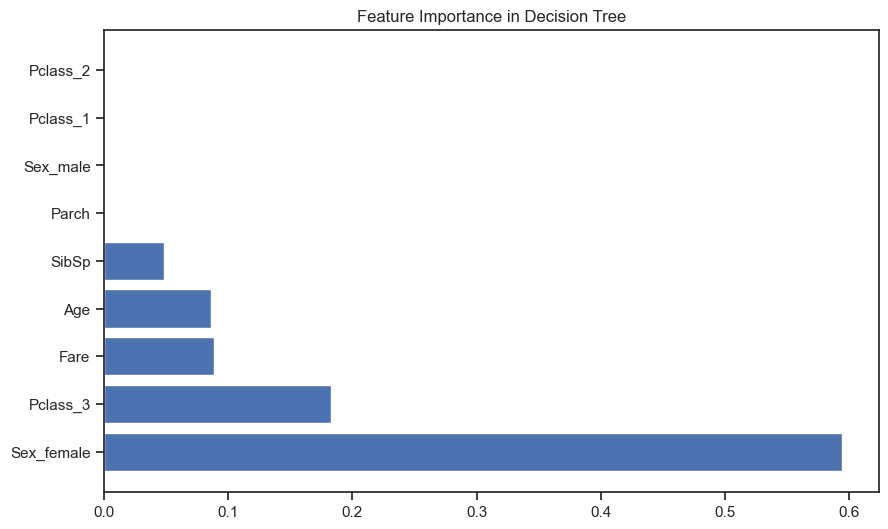

In [13]:
import matplotlib.pyplot as plt

# Извлекаем обученное дерево из pipeline
dt_model = dt_pipeline.named_steps['classifier']

# Важность признаков (учитываем onehot-кодирование)
onehot_columns = dt_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_features = numeric_features + list(onehot_columns)

feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Feature Importance in Decision Tree')
plt.show()

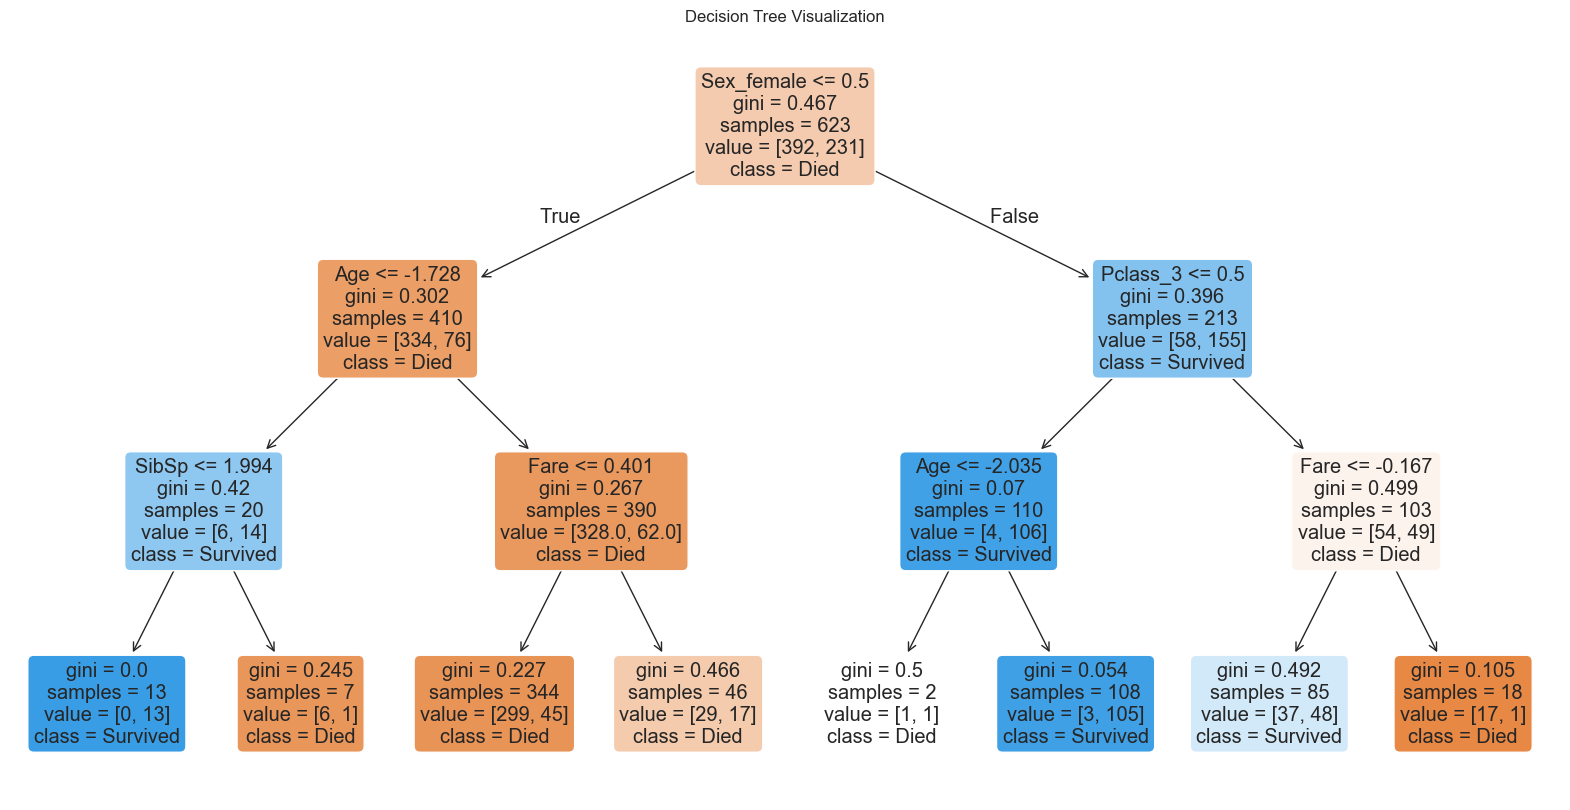

In [14]:
plt.figure(figsize=(20, 10))
plot_tree(dt_model, filled=True, feature_names=all_features, class_names=['Died', 'Survived'], rounded=True)
plt.title("Decision Tree Visualization")
plt.show()